In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
import quandl

df = quandl.get("NSE/TCS", start_date="2013-04-04")


In [3]:
main_date=df.loc['2018-04-04']['Close']

In [4]:
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

#Visualization
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Acer\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#Moving Average  
def MA(df, n):  
    name = 'SMA_' + str(n)
    #MA = pd.Series(pd.rolling_mean(df['Close'], n), name = 'SMA_' + str(n))  
    #df = df.join(MA)  
    df[name]=pd.rolling_mean(df['Close'],n)
    return df

#Exponential Moving Average  
def EMA(df, n):
    name = 'EMA_' + str(n)
    #MA = pd.Series(pd.rolling_mean(df['Close'], n), name = 'SMA_' + str(n))  
    #df = df.join(MA)  
    df[name]=pd.ewma(df['Close'], span = n, min_periods = n - 1)
    return df

In [6]:
for i in [30,40,50]:
    
    MA(df,i)
    
for i in [30,40,50]:
    
    EMA(df,i)

C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=40,center=False).mean()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=30,min_periods=29,adjust=True,ignore_na=False).mean()
C:\Users\Acer\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarni

In [7]:
#Make array of dates
#Last 30 dates will be used for forecasting.
# dates = np.array(df["Date"])
# dates_check = dates[-30:]
# dates = dates[:-30]

dates = np.array(df.index.values)
print(dates)
dates_check = dates[-30:]
dates = dates[:-30]



# define a new feature, HL_PCT
df['HL_PCT'] = (df['High'] - df['Low'])/(df['Low']*100)

# define a new feature percentage change
df['PCT_CHNG'] = (df['Close'] - df['Open'])/(df['Open']*100)

df = df[['Close', 'HL_PCT', 'PCT_CHNG', 'Total Trade Quantity','SMA_30', 'SMA_40', 'SMA_50', 'EMA_30', 'EMA_40', 'EMA_50']]


df.fillna( value=0, inplace=True)
df.isnull().sum()

['2013-04-04T00:00:00.000000000' '2013-04-05T00:00:00.000000000'
 '2013-04-08T00:00:00.000000000' ..., '2018-04-16T00:00:00.000000000'
 '2018-04-17T00:00:00.000000000' '2018-04-18T00:00:00.000000000']


Close                   0
HL_PCT                  0
PCT_CHNG                0
Total Trade Quantity    0
SMA_30                  0
SMA_40                  0
SMA_50                  0
EMA_30                  0
EMA_40                  0
EMA_50                  0
dtype: int64

In [8]:
forecast_out = int(30) # predicting 30 days into future
df['Prediction'] = df[['Close']].shift(-forecast_out) #  label column with data shifted 30 units 
X = np.array(df.drop(['Prediction'], 1))
X = preprocessing.scale(X)
X_forecast = X[-forecast_out:] # set X_forecast equal to last 30
X = X[:-forecast_out] # remove last 30 from X
y = np.array(df['Prediction'])
y = y[:-forecast_out]

In [9]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

In [10]:
# Training
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,y_train)
# Testing
confidence = clf.score(X_test, y_test)
print("confidence: ", confidence)

confidence:  0.948398410571


In [11]:
forecast_prediction = clf.predict(X_forecast)
print(forecast_prediction)

[ 3165.49   3170.255  3170.255  3168.15   3165.49   3172.36   3172.36
  3172.36   3151.495  3131.325  3124.455  3133.36   3126.49   3116.01
  3076.555  3080.115  3074.555  3067.175  3072.01   3075.32   3067.245
  3042.355  3040.25   3043.65   3101.595  3126.815  3124.71   3152.35
  3152.35   3152.35 ]


In [12]:
#Make the final DataFrame containing Dates, ClosePrices, and Forecast values
actual = pd.DataFrame(dates, columns = ["Date"])
actual.set_index("Date", inplace = True)
actual["ClosePrice"] = df["Close"]
actual
actual["Forecast"] = np.nan
# actual.set_index("Date", inplace = True)
forecast = pd.DataFrame(dates_check, columns=["Date"])
forecast["Forecast"] = forecast_prediction
forecast["ClosePrice"] = np.nan
forecast.set_index("Date", inplace = True)
var = [actual, forecast]
result = pd.concat(var)  #This is the final DataFrame
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2013-04-04 to 2018-04-18
Data columns (total 2 columns):
ClosePrice    1215 non-null float64
Forecast      30 non-null float64
dtypes: float64(2)
memory usage: 29.2 KB


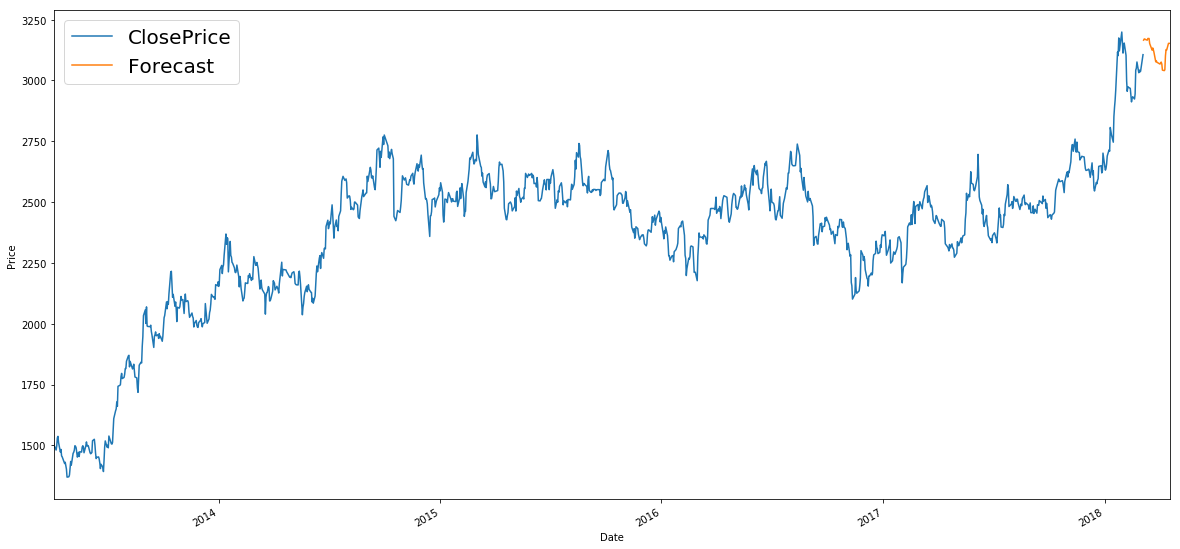

In [13]:
#Plot the results
result.plot(figsize=(20,10), linewidth=1.5)
plt.legend(loc=2, prop={'size':20})
plt.xlabel('Date')
plt.ylabel('Price')

In [14]:
a=result['ClosePrice'].iloc[-31]
b=result['Forecast'].iloc[-1]
ret=((b-main_date)/main_date)*100
ret

8.2946854924593545

In [15]:
sub=pd.read_csv('submission.csv')
sub

,Date,Symbol,Return
0,20180516,TCS.NS,13.03
1,20180516,WIPRO.NS,0.10
2,20180516,AXISBANK.NS,0.58
3,20180516,HCLTECH.NS,-3.34
4,20180516,HDFCBANK.NS,-0.40
5,20180516,ICICIBANK.NS,8.29
6,20180516,INDUSINDBK.NS,-6.13
7,20180516,INFY.NS,0.36
8,20180516,KOTAKBANK.NS,26.29
9,20180516,SBIN.NS,6.90


In [16]:
sub=pd.read_csv('submission.csv')
sub.iloc[2,2]
for i in range(12):
    if sub.loc[i]['Symbol']=='TCS.NS':
        sub.iloc[i,2]="{0:.2f}".format(ret)


In [17]:
sub.to_csv('submission.csv',index=False)
sub

,Date,Symbol,Return
0,20180516,TCS.NS,8.29
1,20180516,WIPRO.NS,0.1
2,20180516,AXISBANK.NS,0.58
3,20180516,HCLTECH.NS,-3.34
4,20180516,HDFCBANK.NS,-0.4
5,20180516,ICICIBANK.NS,8.29
6,20180516,INDUSINDBK.NS,-6.13
7,20180516,INFY.NS,0.36
8,20180516,KOTAKBANK.NS,26.29
9,20180516,SBIN.NS,6.9
